# Air Quality Solutions
## Python Workshop \#2


#### Data
In workshop one, we used data from a single monitoring station in China. In this workshop, we will use data from all 30 provinces of China. The data is stored in the directory `./data/workshop_2/`.

For each province, we have data from 3 monitoring stations, and in each monitoring station we have PM<sub>2.5</sub>, O<sub>3</sub>, NO<sub>2</sub> and SO<sub>2</sub> data. That's 360 columns of data altogether! To make it more managable, the hourly data has been averaged to daily resolution.

#### Content
* MultiIndexes
* Simple maps
* Interactive maps using Geopandas
* Chloropleth maps
* Choosing map projections
* Working with gridded geographical data
* Conditionally selecting data
* Area-weighted and population-weighted means

---
### MultiIndexes
A list of the available files in `./data/workshop_2/` can be obtained using the `glob` package

In [1]:
from glob import glob
filepaths = glob('./data/workshop_2/*.csv') # get a list of the files in that directory
print(filepaths[:5]) # print the first five

['./data/workshop_2/1004A.csv', './data/workshop_2/1006A.csv', './data/workshop_2/1012A.csv', './data/workshop_2/1019A.csv', './data/workshop_2/1021A.csv']


The first step is to load in all the data and combine it into a single dataframe. Previously, we used one dataframe consisting of a column for each pollutant. Now, we have multiple csvs, each with the same pollutants, but each representing a different location. Therefore, we need a way to index the columns by both station and pollutant. We can achieve this with a MultiIndex with two levels. 

In the following cell, a loop loads in each DataFrame, gives it a MultiIndex, then adds it to a list (`dfs`). Finally, the list is concatenated into a single dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

dfs = []
for fpath in filepaths:

    df = pd.read_csv(fpath,  index_col=0, parse_dates=True)
    station_id = fpath[-9:-4] # since all fpaths follow same pattern, can use reverse indexing to extract station_id
    # create MultiIndex
    mindex = pd.MultiIndex.from_product([[station_id]]+[df.columns],
                                       names=['station', 'pollutant'])
    # replace the columns
    df.columns = mindex
    dfs.append(df)

df = pd.concat(dfs, axis=1) # combine all dataframes. axis=1 means horizontally rather than vertically
df

station     1004A                     1006A                     1012A        \
pollutant   PM2.5    O3    NO2   SO2  PM2.5    O3    NO2   SO2  PM2.5    O3   
2015-01-01    NaN   NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN   NaN   
2015-01-02   58.1  20.1   60.9  23.9   53.6  17.1   65.0  32.5   62.3  16.7   
2015-01-03  174.7  14.7   99.0  57.3  140.0   8.3  110.9  71.1  126.5   8.0   
2015-01-04  175.2  15.7  115.2  56.6  155.6  10.6  123.2  64.5  155.2  15.1   
2015-01-05   91.1  31.8   64.7  48.6   88.0  23.7   69.6  53.2  133.0  26.4   
...           ...   ...    ...   ...    ...   ...    ...   ...    ...   ...   
2023-12-27   22.6  22.4   45.5   2.6   28.3  22.8   48.0   2.5   25.6  11.8   
2023-12-28   48.5  10.3   58.7   3.0   51.1  11.6   62.0   2.7   51.0   8.3   
2023-12-29  125.7  10.2   76.6   2.5  110.4  13.8   71.6   2.6   99.7   5.0   
2023-12-30  169.1  17.4   70.1   2.0  147.8  21.6   68.3   2.6  130.3  19.3   
2023-12-31    9.2  57.0   20.8   1.7   10.0  59.5   18.8   1.2   10.1  50.2   

station     ... 2673A       2703A                   2708A                    
pollutant   ...   NO2   SO2 PM2.5    O3   NO2   SO2 PM2.5    O3   NO2   SO2  
2015-01-01  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2015-01-02  ...  15.1   9.9  62.4  17.8  62.3  57.2  16.4  51.8  29.1  34.6  
2015-01-03  ...  18.1  21.8  35.7  11.7  39.6  32.4  16.3  52.7  23.8  44.5  
2015-01-04  ...  21.3  18.6  97.3  18.7  62.5  44.5  14.3  50.6  27.1  31.7  
2015-01-05  ...  13.8  13.8  87.5  13.6  68.0  44.1  16.6  49.4  30.8  22.7  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2023-12-27  ...  27.5  16.0  40.4  27.7  39.5  13.8  13.7  32.1  35.2   5.7  
2023-12-28  ...  26.3  14.0  23.5  37.3  26.1   7.0  18.7  32.7  37.2   4.2  
2023-12-29  ...  22.3  16.0  20.8  50.0  26.0   8.1  12.7  23.2  46.2   4.8  
2023-12-30  ...  26.1  14.7  17.9  49.8  22.6   6.6  12.0  38.0  26.5   4.2  
2023-12-31  ...  26.4  18.0  22.2  38.3  33.4   8.5   8.3  35.3  26.6   4.4  

[3287 rows x 372 columns]

#### Indexing MultiIndexes

MultiIndexes contain several levels of data, in this case two. You can extract the values from each level using the `.get_level_values()` method. For example, to get a list of the `station_id`s:
```python
df.columns.get_level_values('station').unique() # adding unique removes the duplicates
```

Dataframe Multiindexes can still be indexed as normal, e.g. to extract the 2016 data from station `1410A`:

In [3]:
df.loc['2016-01-01':'2016-12-31', '1410A']

pollutant,PM2.5,O3,NO2,SO2
2016-01-01,40.2,76.5,11.0,6.4
2016-01-02,36.2,68.4,11.7,5.8
2016-01-03,38.0,61.0,12.8,3.8
2016-01-04,14.8,51.7,17.7,2.7
2016-01-05,14.3,36.2,31.2,3.7
...,...,...,...,...
2016-12-27,16.4,63.9,12.0,7.4
2016-12-28,27.6,80.6,11.9,9.0
2016-12-29,27.0,95.0,9.9,10.0
2016-12-30,28.1,87.7,13.4,8.9


However, to index using the second level of the columns (in this case `pollutant`), we have to use a slightly different method, using `.xs`.

E.g. to extract the SO2 columns from all the stations:

In [4]:
df.xs(key='SO2', # the value to extract 
      level='pollutant', # which level to extract from 
      axis=1) # 1: columns 0: rows

station,1004A,1006A,1012A,1019A,1021A,1023A,1046A,1050A,1068A,1104A,...,2633A,2642A,2654A,2662A,2669A,2671A,2672A,2673A,2703A,2708A
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,23.9,32.5,35.7,45.6,63.1,46.2,37.1,176.9,26.3,171.9,...,4.0,41.4,68.6,39.1,82.7,22.8,26.6,9.9,57.2,34.6
2015-01-03,57.3,71.1,54.2,153.4,132.1,102.1,160.6,117.8,62.8,65.5,...,3.2,35.2,62.7,98.6,88.3,20.6,47.1,21.8,32.4,44.5
2015-01-04,56.6,64.5,49.2,120.5,176.8,115.7,78.1,195.8,22.8,183.9,...,3.0,26.7,48.8,26.3,45.7,41.2,37.3,18.6,44.5,31.7
2015-01-05,48.6,53.2,56.8,46.5,68.9,30.1,91.1,132.4,9.7,167.1,...,3.1,11.2,110.9,44.4,23.5,42.7,19.2,13.8,44.1,22.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2.6,2.5,3.0,10.6,11.1,9.8,6.7,3.0,4.5,31.5,...,8.0,7.0,6.7,15.6,16.4,10.4,10.1,16.0,13.8,5.7
2023-12-28,3.0,2.7,2.9,7.0,7.1,6.8,10.9,2.9,3.8,39.6,...,8.0,9.5,7.8,15.0,19.7,14.1,7.2,14.0,7.0,4.2
2023-12-29,2.5,2.6,2.8,8.0,7.0,6.2,15.8,3.0,4.2,15.3,...,7.8,6.0,6.0,12.1,15.9,10.7,9.3,16.0,8.1,4.8
2023-12-30,2.0,2.6,2.6,5.5,6.5,6.4,15.7,3.0,3.0,19.6,...,7.4,6.5,6.2,9.8,20.9,9.9,8.7,14.7,6.6,4.2


#### <font color='red'>Question 1</font>

The World Health Organisation's Air Quality Guidelines state that the daily average PM2.5 level should not exceed 15 µg m⁻³ more than 3-4 times a year. 
`df` contains data from 30 different provinces. The metadata contains a columns, `province`, showing which province each station belongs to.

**For each province, calculate the average number of exceedences of 15 µg m⁻³ per year, and show the results using a bar chart.**

Hint: 
* Using `.resample` and `.groupby` will help!
* You need to average twice! Once across the years, and once to average the stations in each province.


<Axes: xlabel='province', ylabel='threshold exceedences\nper year'>

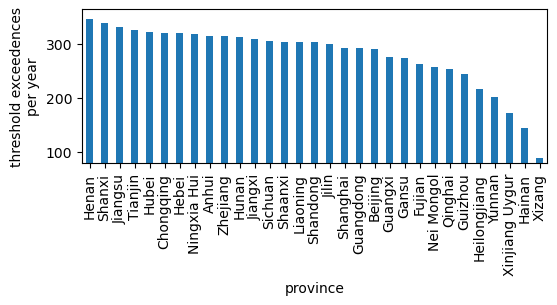

In [5]:
# read in the metadata
meta = pd.read_csv('./metadata.csv', index_col='station_id')

# first, create a series to map each station to its province
provinces = meta.loc[df.columns.get_level_values('station').unique(), 'province']

# calculate the average exceedences per year
annual_exceedences =  (df.xs('PM2.5', level='pollutant', axis=1) > 15).resample('YS').sum()
average_exceedences = annual_exceedences.mean()

average_byprovince = average_exceedences.groupby(provinces).mean()
average_byprovince = average_byprovince.sort_values(ascending=False)
average_byprovince.plot.bar(
    ylim=average_byprovince.min() - 10,
    ylabel='threshold exceedences\nper year',
    figsize=[6,2]
)

### Simple maps

The `geopandas` module can be used to easily create maps from pandas dataframes that contain some type of geographical data. The first step is to convert the `pandas.DataFrame` to a `geopandas.GeoDataFrame`. This can be done using the `gpd.points_from_xy` function. We can apply this to the `meta` dataframe to create a map of the CNEMC monitoring stations in `df`.

Geopandas can also read shapefiles (`.shp`) and add them to the map. A shapefile including China's external and provincial borders has been included in this notebook's data directory.

In the example below, we use two different map projections. The first uses latitude longitude coordinates and an equirectangular projection (`ccrs.PlateCarree`), while the second uses an orthographic projection (`ccrs.Orthographic`) centered on the midpoint of China. The orthographic plot represents China's true shape/area more accurately than lat-lon coordinates. This demonstrates how important it is to choose an appropriate map projection.

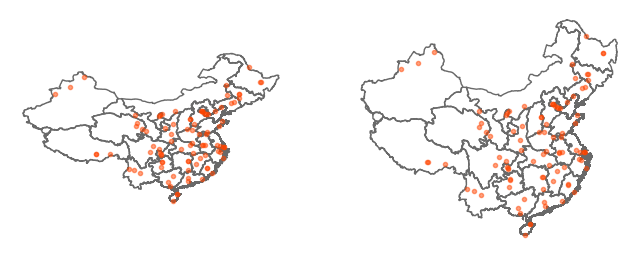

In [6]:
import geopandas as gpd
import cartopy.crs as ccrs

fig, axes = plt.subplots(1,2, figsize=[8,4])

# first subset meta to remove the stations that aren't in df
meta = meta.loc[df.columns.get_level_values('station').unique()]
# then make geodataframe
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(x=meta.lon, y=meta.lat),
                       crs='EPSG:4326' # this tells geopandas we are using latitude-longitude coordinates
                      )
# open China provinces shapefile
provinces = gpd.read_file('./data/workshop_2/gadm41_CHN_1.shp')
# set index as province name
provinces = provinces.set_index('NAME_1')

projections = [ccrs.PlateCarree(), 
               ccrs.Orthographic(central_latitude=36, central_longitude=106)]
# for each projection...
for ax, crs in zip(axes, projections):
    # add China borders shapefile to axis
    provinces.to_crs(crs).plot(ax=ax, edgecolor='dimgrey', facecolor='None')
    # plot points
    gdf.to_crs(crs).plot(ax=ax, color='orangered', marker='.', alpha=.5)
    ax.axis('off') # this removes the axis frame and tickmarks, and ticklabels



### Easy interactive maps with geopandas
Now that the `meta` has been converted into a GeoDataFrame (`gdf`), we can use the `.explore` method of geopandas to easily create an interactive map, including tooltip. You can zoom around the map to view the precise locations of each of the monitoring stations.

The code below creates an interactive map where each point can be clicked on to display the metadata.



In [7]:
gdf.explore(tooltip='station', popup=True, color='red')

### Chloropleth maps

Geopandas can be used to easily create a chloropleth map.

#### <font color='red'>Question 2</font>
__Create 4 maps of the average pollutant concentrations station in each province.__

The geodataframe `provinces` contains the data in the shapefile of China. You can add extra columns to `provinces` using values calculated from `df`. This can be used to plot a chloropleth map by using the the `.plot` method with the argument `column` specifying which column should be used to define the colours.

Tips:
* Use the `province` column in `meta` to do a `groupby` operation on `df`to get the provincial averages.
* In this case, there is no need to use cartopy to create an axis with a projection, geopandas will use the CRS within the `provinces` shapefile

#### <font color='green'>Answer 2</font>

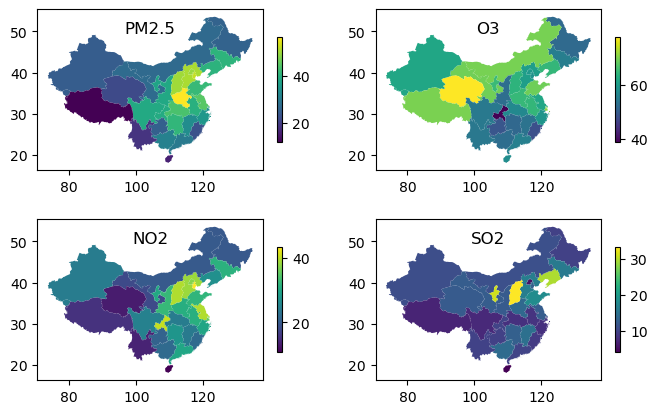

In [8]:
pollutants = ['PM2.5', 'O3', 'NO2', 'SO2']

### First add provincial averages to the borders geodataframe
def get_province_means(pollutant):
    station_means = df.xs(key=pol,  level='pollutant',  axis=1).mean()
    province_means = station_means.groupby(meta.province).mean()
    return province_means

for pol in pollutants:
    provinces[f'{pol}_mean'] = get_province_means(pol)
    # NOTE because 'provinces' and the Series returned by get_province_means have the same index
    # the values are automatically mapped to the correct row

### Second plot the chloropleth maps
fig, axes = plt.subplots(2,2, figsize=[8,5])

for ax, pol in zip(axes.ravel(), pollutants):
    provinces.plot(column=f'{pol}_mean', ax=ax, legend=True, legend_kwds={'shrink':.6})
    ax.set_title(pol, y=.8)

### Gridded geographic data

Working with 'gridded data' is often an essential part of data analysis in environmental science. Gridded data is used to record the spatial and temporal variation of variables across the Earth. Model and satellite data is often 4-dimensional gridded data, e.g. latitude, longitude, height and time. A common file format for storing multi-dimensional gridded data is NetCDF,  which contains the arrays, along with their axis labels (known as co-ordinates) as well as metadata, such as variable names and units.

An example of a 2 dimensional NetCDF array is in this workshop's data repository, at `./data/workshop_2/population.nc`. NetCDFs can be opened using the `xarray` package, which can be thought of as a version of pandas suitable for n-dimensional arrays. 

In [9]:
import xarray as xr
ds = xr.open_dataset('./data/workshop_2/population.nc')
print(ds)

<xarray.Dataset> Size: 224MB
Dimensions:           (lon: 4320, lat: 2160, year: 5)
Coordinates:
  * lon               (lon) float64 35kB 0.02083 0.0625 0.1042 ... 179.9 180.0
  * lat               (lat) float64 17kB 0.02083 0.0625 0.1042 ... 89.94 89.98
  * year              (year) int64 40B 2000 2005 2010 2015 2020
Data variables:
    population_count  (year, lat, lon) float32 187MB ...
    country_id        (lat, lon) float32 37MB ...
Attributes:
    units:      Persons
    long_name:  Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 a...
    min:        [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.00...
    max:        [9.63072875e+05 1.00347762e+06 1.13291988e+06 1.34768400e+06\...
    source:      https://doi.org/10.7927/H49C6VHW
    version:    4.11


The information above summarises the xarray `Dataset`'s contents.

`Dimensions: (lon: 4320, lat: 2160, year: 5)` shows that the Dataset has a shape of 4320 x 2160 x 5, and they are named 'lon', 'lat', 'year'.

The `Coordinates` section shows us that each of the dimensions has a label, and that `lon` and `lat` are labelled with floats (decimals) ranging from 0-180 and 0-90 respectively. This tells us that the data we have covers a quarter of the globe (the eastern half of the northern hemisphere).

The `Data variables` section shows us that there are two different variables contained in the dataset. One of them, `population_count`, occupies all three of the dataset's dimensions, whereas `country_id` does not occupy the time dimension (so is 2d). 

Finally, `Attributes` contains useful metadata.

Let's create a plot of each variable so we know what we are dealing with. Variables are accessed by indexing the `Dataset`. Each variable is stored in an object called a `DataArray`. Multiple `DataArray`s make up a `Dataset` (in this case two)

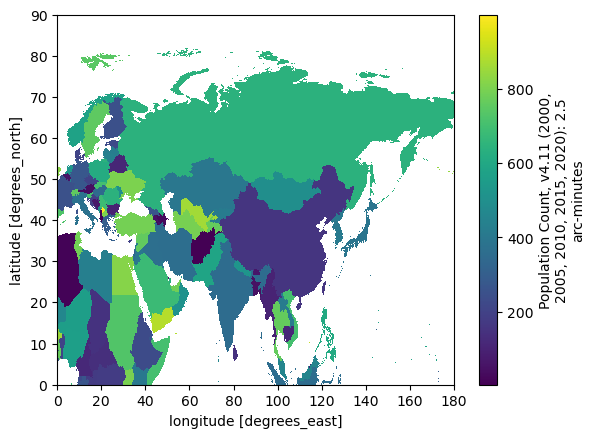

In [10]:
ds['country_id'].plot.imshow()

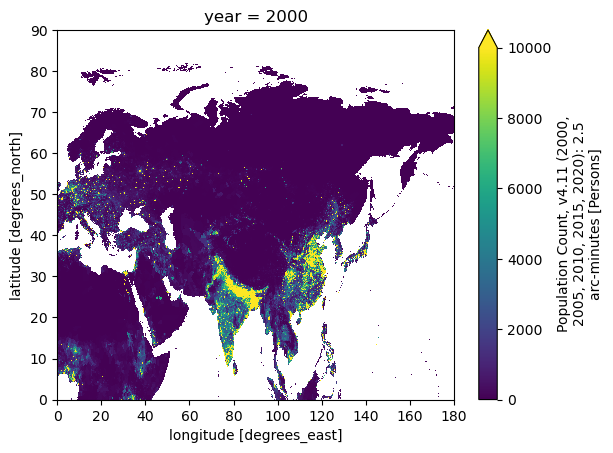

In [11]:
ds['population_count'][0].plot.imshow(vmax=10000)

### Plotting gridded data on different map projections
It is often the case that we want to plot geographic gridded data on a axis with a different map projection. If this is the case, we need to tell python what co-ordinate system our data uses so it can transform the data to match the axis is it being plotted on. We do this using the `transform` keyword. For example, the plot above has latitude and longitude, so by adding the `transform=ccrs.PlateCarree()` argument to `.plot()` method, we can plot it on any other cartopy map projection, e.g.

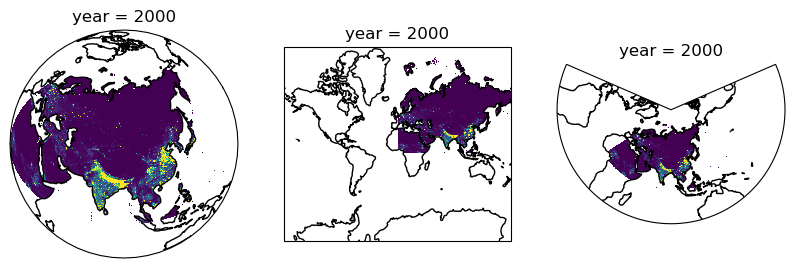

In [12]:
projections = [ccrs.Orthographic(central_latitude=45, central_longitude=90), 
               ccrs.Mercator(), ccrs.LambertConformal(central_longitude=90)]
fig = plt.figure(figsize=[10,10])
for i, proj in enumerate(projections):
    ax = fig.add_subplot(1,3,i+1, projection=proj) # in each iteration, create an axis with 'proj'
    pda = ds['population_count'][0].plot.imshow(vmax=10000,
                                         transform=ccrs.PlateCarree(),# this ensures the data is transformed FROM lat-lon coordinates
                                         ax=ax, add_colorbar=False)
    ax.coastlines()

#### <font color='red'>Question 3</font>

As the `ds['country_id']` plot above demonstrates, one of the variables (`country_id`) in the Dataset represents contains numbers which represent the spatial extent of each country. The mapping of number to country is contained in a text file, which is in this notebook's data folder, and is called `national_identifier_grid_lookup.txt`. Using your knowledge from Workbook 1, read this file into the notebook as a pandas dataframe so it can be used to subset the data. The dataframe should have the 'ISOCODE' column, a three letter string to identify each country, as its row index.

__Read in the national identifier lookup into a variable named `lookup`__



In [13]:
lookup = pd.read_csv('./data/workshop_2/national_identifier_grid_lookup.txt', sep='\t') # open the .txt file as a csv
lookup = lookup.set_index('ISOCODE') # change the index to be the ISOCODE column

### Using `.where()` to conditionally select data

The `lookup` table you have just read in can be used to subset the data by country. To do this, the `.where()` method of a `DataArray` can be used. `.where()` should be supplied with a boolean (True/False) array matching the dimensions of the array it is called from. For example, to select Russia

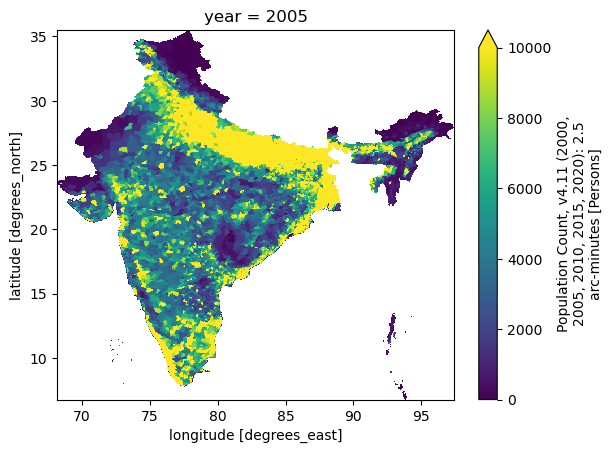

In [14]:
india_id = lookup.loc['IND', 'Value'] # get the value that represents India from the dataframe
india_pop = ds['population_count'].loc[{'year':2005}].where(ds['country_id'] == india_id) # conditionally select the data using this value
india_pop = india_pop.dropna('lat', how='all').dropna('lon', how='all') # remove empty rows in the array
india_pop.plot.imshow(vmax=1e4) # imshow is used to plot gridded data

#### <font color='red'>Question 4</font>

Transform the above code into a function that accepts two arguments, `country_isocode` and `year` and returns the population count array of desired country. This will make it easier to get the data you need for this question. Use the function to make three figures:

1. A figure with two axes, showing Russia's population in 2010 projected using the PlateCarree projection on the left hand axis, and an Orthographic projection centered on Russia on the right hand axis.
2. A plot showing the change in population in China from 2000 to 2020. Include the provincial borders loaded previously in the notebook.
3. A line graph comparing the total population of China and India during 2000-2020

Hints:
* To make a figure that has two axes with different projections, first make a figure using `plt.figure` then add an axes with your desired projections (e.g. `ccrs.PlateCarree()`) to the figure using `fig.add_subplot`.

#### <font color='green'>Answer 4</font>

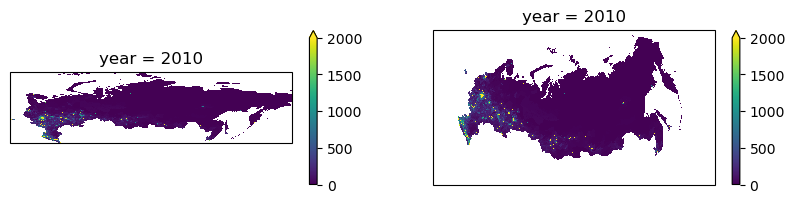

In [15]:
def get_country_population(country_isocode, year=None):
    country_id = lookup.loc[country_isocode, 'Value']
    country_pop = ds['population_count'].where(ds['country_id'] == country_id)
    if year:
        country_pop = country_pop.loc[{'year':year}]
    country_pop = country_pop.dropna('lat', how='all').dropna('lon', how='all')
    return country_pop

### 1 ###
russia_pop = get_country_population('RUS', year=2010)

# create a figur
fig = plt.figure(figsize=[10,10])
ll_ax = fig.add_subplot(121, projection=ccrs.PlateCarree()) # add an axis with a PlateCarree map projection
orth_ax = fig.add_subplot(122, projection=ccrs.Orthographic(central_latitude=66.755, central_longitude=93.85)) #axis with a Orthographic map projection

for ax in (ll_ax, orth_ax):
    russia_pop.plot(ax=ax, transform=ccrs.PlateCarree(),
                   vmax=2000, 
                    cbar_kwargs={'shrink':.2, 'label':''})
    

<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

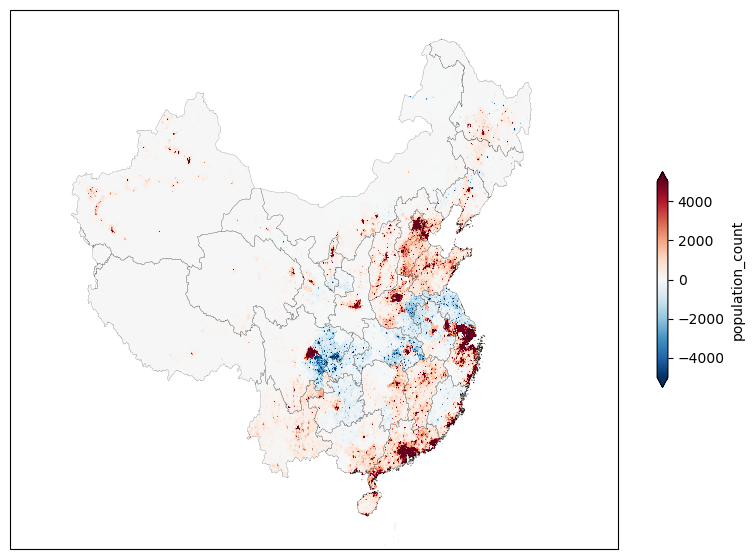

In [16]:
### 2 ###
china_pop_change = get_country_population('CHN', year=2020) - get_country_population('CHN', year=2000)
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(projection=ccrs.Orthographic(central_latitude=36, central_longitude=106))
china_pop_change.plot(ax=ax, transform=ccrs.PlateCarree(),
                     cbar_kwargs={'shrink':.4},
                     vmin=-5000, vmax=5000, 
                     cmap='RdBu_r')
# plot the provinces on top of the data (otherwise they would be invisible)
provinces.plot(ax=ax, transform=ccrs.PlateCarree(), facecolor='None', edgecolor='black',
               linewidth=.1)


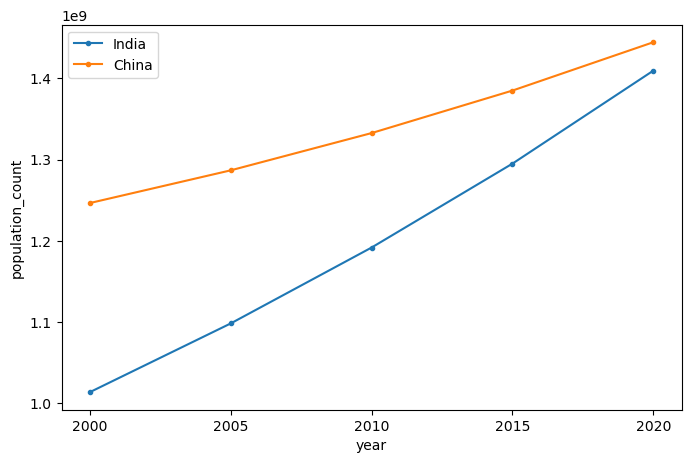

In [17]:
### 3 ###
india_total_pop = get_country_population('IND').sum(['lat', 'lon'])
china_total_pop = get_country_population('CHN').sum(['lat', 'lon'])

fig, ax = plt.subplots(figsize=[8,5])
india_total_pop.plot(ax=ax, marker='.', label='India')
china_total_pop.plot(ax=ax, marker='.', label='China')
ax.legend()
ax.set_xticks(range(2000, 2025, 5))

### Population-weighted means
When we want to compare how bad pollution is in different areas, it can be useful to take a spatial average of all the data we have in each area. But what we really care about, for the purpose of health impacts, is 'exposure', i.e. how much pollution is actually being breathed in? For this, we need to integrate population distribution into our metric. A common way of achieving this is is a 'population-weighted mean'. 

To calculate a normal mean, we divide the sum of the values by the number of values. For a weighted-mean, we first multiply each value by its weighting factor, then divide by the sum of the weights. So to calculate a population-weighted mean from gridded data, sum the values of PM2.5 concentrations multiplied by the population, then divide by the sum of the population. Here is the formula:

$$
\text{Population-weighted mean} = \frac{\sum_{i=1}^{n} x_i P_i}{\sum_{i=1}^{n} P_i}
$$
Where $x$ is the variable of interest (in this case PM2.5), and $P$ is population.

For this next section, we will need gridded PM2.5 data that matches the population data. This is contained in a netcdf file called `gridded_pm25.nc`:

<xarray.Dataset> Size: 65MB
Dimensions:         (lon: 1536, lat: 885, year: 5)
Coordinates:
  * lon             (lon) float64 12kB 72.23 72.27 72.31 ... 136.1 136.1 136.2
  * lat             (lat) float64 7kB 17.23 17.27 17.31 ... 53.98 54.02 54.06
  * year            (year) int32 20B 2000 2005 2010 2015 2020
Data variables:
    pm25            (year, lat, lon) float64 54MB ...
    gridcell_areas  (lon, lat) float64 11MB ...
Attributes:
    regrid_method:  bilinear


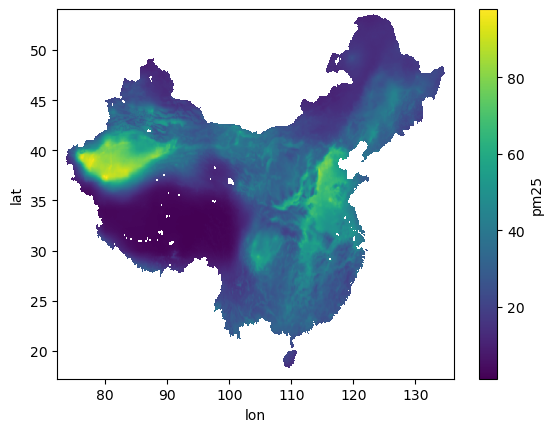

In [18]:
gridded_pm = xr.open_dataset('./data/workshop_2/gridded_pm25.nc')
print(gridded_pm)
gridded_pm['pm25'].mean('year').plot()

### Area weighted means
Notice that this file also includes a variable called `gridcell_areas`. This is because the area in a latitude-longitude gridcell (e.g. a rectangle on the Earth's surface defined by latitude/longitude limits) varies with latitude. This is because lines of longitude converge at the poles, so as latitude increases, the size of regularly spaced gridcells decreases. This is demonstrated by the diagram below.

<img src="./assets/gridcell_area_diagram.png" alt="Descriptive Alt Text" width="300">

This means that when taking a mean of gridded data, especially when the data spans a large area or is global in extent, you should take an area-weighted means, so gridcells contribute to the mean relative to their actual size.

#### <font color='red'>Question 5</font>
In China, the population-weighted mean can be quite different from the area-weighted mean. This is particularly because, as shown in the figure above, some very high PM2.5 concentrations are found in areas with low population (e.g. desert regions).


**Calculate the area and population-weighted means from using gridded PM2.5 reanalysis data, and plot them on a line graph with year as the x axis and mean PM2.5 as the y axis, to compare how they have changed over time.**

Tips:
* use the `gridcell_areas` variable in the gridded PM2.5 data to calculate the area-weighted mean.
* The data is 3D (time, lat, lon). We want to calculate the mean across latitude and longitude for each year, so when calculating the sum, only sum over lat and lon (not year).
* We only want to sum the area of gridcells where there is PM data (see plot above). Use `.where()` to achieve this.
* Don't worry if dimensions are in different orders on the two DataArrays, xarray will use the coordinates to match them

#### <font color='green'>Answer 5</font>

Text(0, 0.5, 'µg m⁻³')

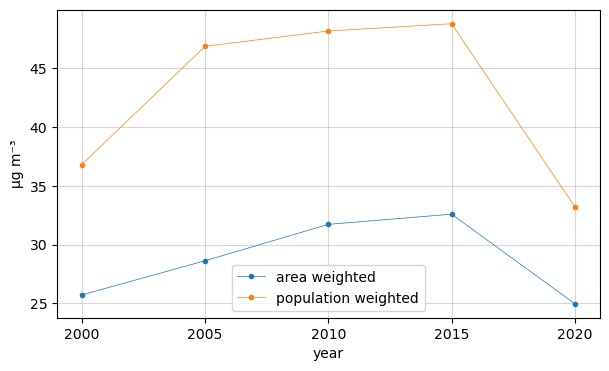

In [19]:
## area-weighted mean
# mask the gridcell_areas array by the PM array
areas_china_only = gridded_pm['gridcell_areas'].where(gridded_pm['pm25'][0].notnull())
area_weighted = (gridded_pm['pm25'] * areas_china_only).sum(['lat', 'lon']) / areas_china_only.sum(['lat', 'lon'])

## population-weighted mean
china_pop = get_country_population('CHN')
population_weighted = (gridded_pm['pm25'] * china_pop).sum(['lat', 'lon']) / china_pop.sum(['lat', 'lon'])

fig, ax = plt.subplots(figsize=[7,4])
area_weighted.plot(label='area weighted', ax=ax, marker='.', lw=.5)
population_weighted.plot(label='population weighted', ax=ax, marker='.', lw=.5)
ax.legend()
ax.grid(alpha=.5)
ax.set_xticks(gridded_pm.year)
ax.set_ylabel('µg m⁻³')

## NOTE: if area weighted means are too low ([10.28340692, 11.44663217, 12.68594054, 13.03205397,  9.98538489]) then they did not mask area array
## NOTE: this can also be done using DataArray.weighted() which is much easier, but hopefully they don't realise this!